<a href="https://colab.research.google.com/github/siva8696/Naive-Bayes-on-Cancer-Diagnosis/blob/master/Naive_Bayes_on_Cancer_Diagnosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2>Personalized cancer diagnosis

**Description :**

Source: https://www.kaggle.com/c/msk-redefining-cancer-treatment/

Data: Memorial Sloan Kettering Cancer Center (MSKCC)

Download training_variants.zip and training_text.zip from Kaggle.

Context:
Source: https://www.kaggle.com/c/msk-redefining-cancer-treatment/discussion/35336#198462

Problem statement :
Classify the given genetic variations/mutations based on evidence from text-based clinical literature.

**Real-world/Business objectives and constraints.**

* No low-latency requirement.
* Interpretability is important.
* Errors can be very costly.
* Probability of a data-point belonging to each class is needed.

**ML Problem formulation :**

**Data Overview**

- Source: https://www.kaggle.com/c/msk-redefining-cancer-treatment/data
- We have two data files: one conatins the information about the genetic mutations and the other contains the clinical evidence (text) that  human experts/pathologists use to classify the genetic mutations. 
- Both these data files are have a common column called ID
- <p> 
    Data file's information:
    <ul> 
        <li>
        training_variants (ID , Gene, Variations, Class)
        </li>
        <li>
        training_text (ID, Text)
        </li>
    </ul>
</p>

**Objective and Constraints :**

Objective: Predict the probability of each data-point belonging to each of the nine classes.

Constraints:

* Interpretability * Class probabilities are needed. * Penalize the errors in class probabilites => Metric is Log-loss. * No Latency constraints.

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
#from sklearn.cross_validation import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")

from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression


**Reading Data**

**Reading Training Variants and Text data :**

In [3]:
import os
cwd = os.getcwd()
#print(cwd)
files = os.listdir(cwd)
#print(files)
data_var= pd.read_csv("sample_data/Case_Study1/training_variants")
#data_text=pd.read_csv("Case_Study1/training_text")
print("The Shape of the varaiants data is :",data_var.shape)
print("The total number of data points in variants data is",data_var.shape[0])
print("The total number of features in variants data is",data_var.shape[1])
print("The features are :",data_var.columns.values)
print("*"*50)
print(data_var.head())

The Shape of the varaiants data is : (3321, 4)
The total number of data points in variants data is 3321
The total number of features in variants data is 4
The features are : ['ID' 'Gene' 'Variation' 'Class']
**************************************************
   ID    Gene             Variation  Class
0   0  FAM58A  Truncating Mutations      1
1   1     CBL                 W802*      2
2   2     CBL                 Q249E      2
3   3     CBL                 N454D      3
4   4     CBL                 L399V      4


In [4]:
data_text=pd.read_csv("sample_data/Case_Study1/training_text" , sep="\|\|", names=["ID","Text"], skiprows=1)
print("The Shape of the test data is :",data_text.shape)
print("The total number of data points in text data is",data_text.shape[0])
print("The total number of features in text data is",data_text.shape[1])
print("The features are :",data_text.columns.values)
print("*"*50)
print(data_text.head())

The Shape of the test data is : (3321, 2)
The total number of data points in text data is 3321
The total number of features in text data is 2
The features are : ['ID' 'Text']
**************************************************
   ID                                               Text
0   0  Cyclin-dependent kinases (CDKs) regulate a var...
1   1   Abstract Background  Non-small cell lung canc...
2   2   Abstract Background  Non-small cell lung canc...
3   3  Recent evidence has demonstrated that acquired...
4   4  Oncogenic mutations in the monomeric Casitas B...


**Preprocessing on  Text :**

In [5]:
import nltk
stop_words1 = nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
print(stop_words)

{'do', 're', 'ma', "weren't", 'aren', "wouldn't", 'too', 'below', "doesn't", 'ours', 'an', 'between', 'it', "that'll", 'itself', 'while', 'your', "mightn't", 'this', 'because', 'herself', "shan't", 'yourselves', 'been', 'these', 'and', 'wouldn', 'not', 'but', 'were', 'when', 'himself', 'nor', "you're", 'few', "should've", 'those', 'until', 'further', 'haven', 'be', 'in', 'have', 'hadn', "you've", 'ain', 'up', 'hasn', 'more', 've', "haven't", 'how', "mustn't", 't', 'did', 'having', 'that', 'd', 'through', 'only', 'into', 'should', 'won', 'again', 'other', 'my', 'so', 'with', 'm', 'own', 'will', 'against', 'just', 'll', 'about', 'doing', 'same', 'yourself', 'theirs', 'its', "aren't", 'for', 'can', 'above', 'they', 'under', "hadn't", 'ourselves', 'mustn', 'here', 'very', "couldn't", 'her', 'there', 'yours', 'where', 'then', 'doesn', 'some', 'hers', 'any', 'does', 'was', 'after', "shouldn't", 'wasn', 'myself', 'over', 'couldn', 'our', 'at', 'y', "needn't", 'both', "you'd", 'from', 'mightn'

In [0]:
def nlp_preprocessing(text,index, column):
  if type(text) is not int:
    #Intiallizing the empty string
    string = ""
    #Removing the specail character and replace it with space
    text = re.sub('[^a-zA-Z0-9\n]',' ',text)
    #Removing the multiple spaces and replace it with single space
    text = re.sub('\s+',' ',text)
    #Converting the text into lower_case
    text = text.lower()
    #Removing the stop words from text and saving back into String
    
    for word in text.split():
      if not word in stop_words:
        string += word + " "
    data_text[column][index]=string
        

In [8]:
#Checking the starting time
start_time = time.clock()
#Using iterrows we are iterating the data frame with index 
for index, row in data_text.iterrows():
  if type(row['Text']) is str:
    nlp_preprocessing(row['Text'],index,'Text')
  else:
    print("There is no string at Index:", index)
print("Time taking to process the text data is :",time.clock()-start_time,"Seconds")

There is no string at Index: 1109
There is no string at Index: 1277
There is no string at Index: 1407
There is no string at Index: 1639
There is no string at Index: 2755
Time taking to process the text data is : 29.791248000000003 Seconds


In [9]:
#Merging the both Gene variations and Text data using ID
final_data = pd.merge(data_var,data_text, on = 'ID', how='left')
print(final_data.head())

   ID    Gene  ... Class                                               Text
0   0  FAM58A  ...     1  cyclin dependent kinases cdks regulate variety...
1   1     CBL  ...     2  abstract background non small cell lung cancer...
2   2     CBL  ...     2  abstract background non small cell lung cancer...
3   3     CBL  ...     3  recent evidence demonstrated acquired uniparen...
4   4     CBL  ...     4  oncogenic mutations monomeric casitas b lineag...

[5 rows x 5 columns]


In [10]:
final_data[final_data.isnull().values.any(axis=1)]

,ID,Gene,Variation,Class,Text
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [0]:
final_data.loc[final_data['Text'].isnull(), 'Text'] = final_data['Gene']+' '+final_data['Variation']

<h3>Splitting the data into Train and CV and Test :</h3>

In [0]:
y_value = final_data['Class'].values
#Dividing the data into Train and Test and CV and Stratify make the class label in same distribution
X_train, X_test, y_train, y_test = train_test_split(final_data, y_value, stratify=y_value, test_size=0.2, random_state=42)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train ,test_size=0.2, random_state=42)

In [13]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)
print("Number of data points in cv data :",X_cv.shape)

Number of data points in train data : (2124, 5)
Number of data points in test data : (665, 5)
Number of data points in cv data : (532, 5)


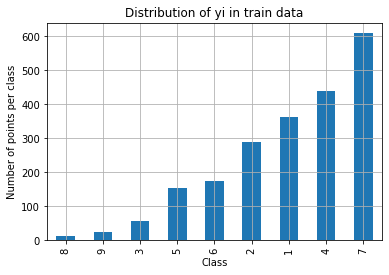

**************************************************


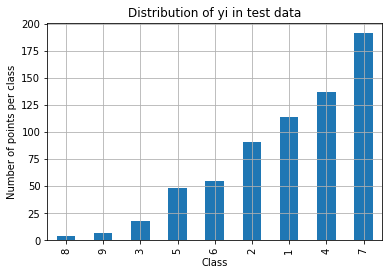

**************************************************


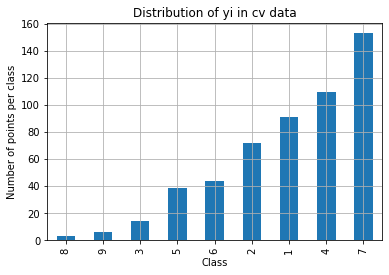

In [14]:
train_class_distribution=X_train['Class'].value_counts().sort_values()
#Plotting the distribution of yi in train data
my_colors = 'rgbkymc'
train_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Number of points per class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()


print('*'*50)

test_class_distribution=X_test['Class'].value_counts().sort_values()
#Plotting the distribution of yi in test data
my_colors='rgbkymc'
test_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Number of points per class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()

print('*'*50)

cv_class_distribution=X_cv['Class'].value_counts().sort_values()
#Plotting the distribution of yi in test data
my_colors = 'rgbkymc'
cv_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Number of points per class')
plt.title('Distribution of yi in cv data')
plt.grid()
plt.show()

**Confusion Matrix, Precision, Re-call :**

In [0]:
def plot_confusion_matrix(y_test, y_pred):
  #Confusion matrix
  A = confusion_matrix(y_test,y_pred)
  #Precision matrix
  B = (((A.T)/(A.sum(axis=1))).T)
  #Recall matrix
  C = (A/A.sum(axis=0))

  labels = [1,2,3,4,5,6,7,8,9]
  #Plot the consuion matrix
  print("-"*20,"Confusion matrix","-"*20)
  plt.figure(figsize=(20,7))
  sns.heatmap(A,annot=True,cmap="YlGnBu",fmt=".3f",xticklabels=labels,yticklabels=labels)
  plt.xlabel("predicted Class")
  plt.ylabel("Actual Class")
  plt.show()

  #Plot the precision matrix
  print("-"*20,"Precision matrix (Column Sum = 1)","-"*20)
  plt.figure(figsize=(20,7))
  sns.heatmap(C,annot=True,cmap="YlGnBu",fmt=".3f",xticklabels=labels,yticklabels=labels)
  plt.xlabel("predicted Class")
  plt.ylabel("Actual Class")
  plt.show()

  #Plot the recall matrix
  print("-"*20,"Recall matrix (Row Sum = 1)","-"*20)
  plt.figure(figsize=(20,7))
  sns.heatmap(B,annot=True,cmap="YlGnBu",fmt=".3f",xticklabels=labels,yticklabels=labels)
  plt.xlabel("predicted Class")
  plt.ylabel("Actual Class")
  plt.show()


**Univariate analysis in Gene feature:**

In [16]:
unique_gene = X_train['Gene'].value_counts()
print("Number of unique Gene features are:",unique_gene[0])
print(unique_gene.head(10))

Number of unique Gene features are: 154
BRCA1     154
TP53      104
EGFR       89
PTEN       88
BRCA2      83
KIT        63
BRAF       60
ALK        43
PDGFRA     41
ERBB2      41
Name: Gene, dtype: int64


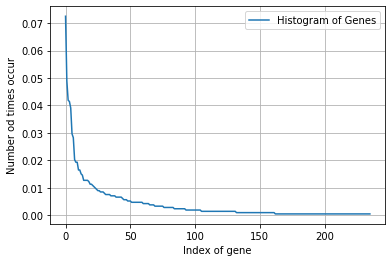

In [17]:
#print(unique_gene.values)
#print(sum(unique_gene.values))
s = sum(unique_gene.values)
h = unique_gene.values/s
plt.plot(h,label="Histogram of Genes")
plt.xlabel("Index of gene")
plt.ylabel("Number od times occur")
plt.legend()
plt.grid()
plt.show()

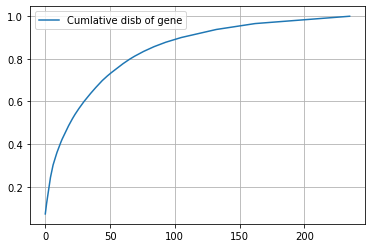

In [18]:
t = np.cumsum(h)
plt.plot(t,label="Cumlative disb of gene")
plt.legend()
plt.grid()
plt.show()

In [19]:
#Featurization for Gene feature using Tfidf Vectorizer
gene_vectorizer = TfidfVectorizer(stop_words='english',ngram_range=(1,2))
train_gene_feature_tfidf = gene_vectorizer.fit_transform(X_train['Gene'])
cv_gene_feature_tfidf = gene_vectorizer.transform(X_cv['Gene'])
test_gene_feature_tfidf = gene_vectorizer.transform(X_test['Gene'])
print(train_gene_feature_tfidf.shape)
print(cv_gene_feature_tfidf.shape)
print(test_gene_feature_tfidf.shape)

(2124, 236)
(532, 236)
(665, 236)


For the alpha value  1e-05 the logg loss is : 1.2487164002213615
For the alpha value  0.0001 the logg loss is : 1.248691163999263
For the alpha value  0.001 the logg loss is : 1.248442717442302
For the alpha value  0.01 the logg loss is : 1.2462831711632387
For the alpha value  0.1 the logg loss is : 1.2380940279209514
For the alpha value  1 the logg loss is : 1.248320862446043
For the alpha value  10 the logg loss is : 1.3289215869798057
For the alpha value  100 the logg loss is : 1.3791063697532326
For the alpha value  1000 the logg loss is : 1.3872131920613666


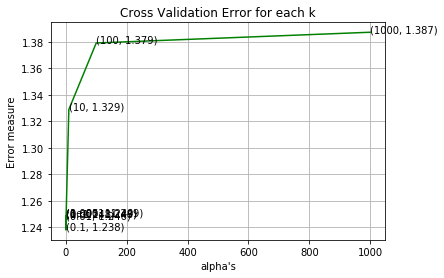

For values of best alpha =  0.1 The train log loss is: 1.0726203394183564
For values of best alpha =  0.1 The cross validation log loss is: 1.2380940279209514
For values of best alpha =  0.1 The test log loss is: 1.3031363754975405


In [20]:
alpha = [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000 ]
cv_log_error = []
for i in alpha:
  clf=MultinomialNB(alpha=i)
  clf.fit(train_gene_feature_tfidf,y_train)
  sig_clf=CalibratedClassifierCV(clf,method='sigmoid')
  sig_clf.fit(train_gene_feature_tfidf,y_train)
  predicted_y=sig_clf.predict_proba(cv_gene_feature_tfidf)
  cv_log_error.append(log_loss(y_cv,predicted_y,labels=clf.classes_,eps=1e-15))
  print("For the alpha value ",i,"the logg loss is :",log_loss(y_cv,predicted_y,labels=clf.classes_,eps=1e-15))


fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error,c='g')
for i, txt in enumerate(np.round(cv_log_error,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error[i]))
plt.grid()
plt.title("Cross Validation Error for each k")
plt.xlabel("alpha's")
plt.ylabel("Error measure")
plt.show()


best_alpha_gene = np.argmin(cv_log_error)
clf = MultinomialNB(alpha=alpha[best_alpha_gene])
clf.fit(train_gene_feature_tfidf, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gene_feature_tfidf, y_train)

predict_y_gene = sig_clf.predict_proba(train_gene_feature_tfidf)
print('For values of best alpha = ', alpha[best_alpha_gene], "The train log loss is:",log_loss(y_train, predict_y_gene, labels=clf.classes_, eps=1e-15))
predict_y1_gene = sig_clf.predict_proba(cv_gene_feature_tfidf)
print('For values of best alpha = ', alpha[best_alpha_gene], "The cross validation log loss is:",log_loss(y_cv, predict_y1_gene, labels=clf.classes_, eps=1e-15))
predict_y2_gene = sig_clf.predict_proba(test_gene_feature_tfidf)
print('For values of best alpha = ', alpha[best_alpha_gene], "The test log loss is:",log_loss(y_test, predict_y2_gene, labels=clf.classes_, eps=1e-15))


In [21]:
print("Q6. How many data points in Test and CV datasets are covered by the ", unique_gene.shape[0], " genes in train dataset?")

test_coverage=X_test[X_test['Gene'].isin(list(set(X_train['Gene'])))].shape[0]
cv_coverage=X_cv[X_cv['Gene'].isin(list(set(X_train['Gene'])))].shape[0]

print('Ans\n1. In test data',test_coverage, 'out of',X_test.shape[0], ":",(test_coverage/X_test.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',X_cv.shape[0],":" ,(cv_coverage/X_cv.shape[0])*100)

Q6. How many data points in Test and CV datasets are covered by the  236  genes in train dataset?
Ans
1. In test data 642 out of 665 : 96.54135338345866
2. In cross validation data 523 out of  532 : 98.30827067669173


As per the above analysis the Gene feature will be helpful for us to creating the model. Along with that we can see almost more than 96 percentage of test gene features are available in train gene.

**Univariate analysis on Variant feature :**

In [22]:
unique_var = X_train['Variation'].value_counts()
print("Number of unique Gene features are:",unique_var[0])
print(unique_var.head(10))

Number of unique Gene features are: 66
Truncating Mutations    66
Amplification           47
Deletion                42
Fusions                 23
Overexpression           4
T58I                     3
Q61H                     2
C618R                    2
S222D                    2
P34R                     2
Name: Variation, dtype: int64


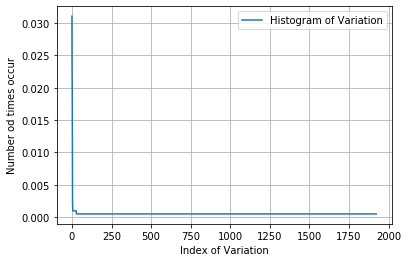

In [23]:
#print(unique_gene.values)
#print(sum(unique_gene.values))
s = sum(unique_var.values)
h = unique_var.values/s
plt.plot(h,label="Histogram of Variation")
plt.xlabel("Index of Variation")
plt.ylabel("Number od times occur")
plt.legend()
plt.grid()
plt.show()

In [24]:
#Tfidf Vectorizer for Variation feature
tfidf = TfidfVectorizer(stop_words="english",ngram_range=(1,2))
train_var_feature_tfidf = tfidf.fit_transform(X_train['Variation'])
cv_var_feature_tfidf = tfidf.transform(X_cv['Variation'])
test_var_feature_tfidf = tfidf.transform(X_test['Variation'])
print(train_var_feature_tfidf.shape)
print(cv_var_feature_tfidf.shape)
print(test_var_feature_tfidf.shape)

(2124, 2119)
(532, 2119)
(665, 2119)


For the alpha value  1e-05 the logg loss is : 1.7920003154758302
For the alpha value  0.0001 the logg loss is : 1.7924191288569575
For the alpha value  0.001 the logg loss is : 1.791299613182014
For the alpha value  0.01 the logg loss is : 1.7688201326683484
For the alpha value  0.1 the logg loss is : 1.7441553015447608
For the alpha value  1 the logg loss is : 1.6987643951098692
For the alpha value  10 the logg loss is : 1.697635071093964
For the alpha value  100 the logg loss is : 1.698714787232528
For the alpha value  1000 the logg loss is : 1.6984543205679647


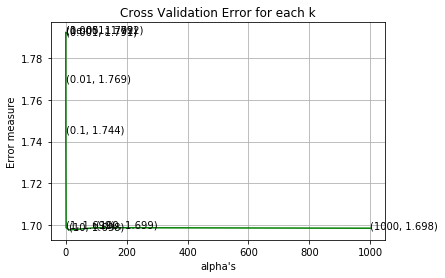

For values of best alpha =  10 The train log loss is: 1.3913138101882896
For values of best alpha =  10 The cross validation log loss is: 1.697635071093964
For values of best alpha =  10 The test log loss is: 1.7324416685743982


In [25]:
alpha = [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000 ]
cv_log_error = []
for i in alpha:
  clf=MultinomialNB(alpha=i)
  clf.fit(train_var_feature_tfidf,y_train)
  sig_clf=CalibratedClassifierCV(clf,method='sigmoid')
  sig_clf.fit(train_var_feature_tfidf,y_train)
  predicted_y=sig_clf.predict_proba(cv_var_feature_tfidf)
  cv_log_error.append(log_loss(y_cv,predicted_y,labels=clf.classes_,eps=1e-15))
  print("For the alpha value ",i,"the logg loss is :",log_loss(y_cv,predicted_y,labels=clf.classes_,eps=1e-15))


fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error,c='g')
for i, txt in enumerate(np.round(cv_log_error,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error[i]))
plt.grid()
plt.title("Cross Validation Error for each k")
plt.xlabel("alpha's")
plt.ylabel("Error measure")
plt.show()

best_alpha_var = np.argmin(cv_log_error)
#print(alpha[best_alpha_var])
clf = MultinomialNB(alpha=alpha[best_alpha_var])
clf.fit(train_var_feature_tfidf, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_var_feature_tfidf, y_train)

predict_y_var = sig_clf.predict_proba(train_var_feature_tfidf)
print('For values of best alpha = ', alpha[best_alpha_var], "The train log loss is:",log_loss(y_train, predict_y_var, labels=clf.classes_, eps=1e-15))
predict_y1_var = sig_clf.predict_proba(cv_var_feature_tfidf)
print('For values of best alpha = ', alpha[best_alpha_var], "The cross validation log loss is:",log_loss(y_cv, predict_y1_var, labels=clf.classes_, eps=1e-15))
predict_y2_var = sig_clf.predict_proba(test_var_feature_tfidf)
print('For values of best alpha = ', alpha[best_alpha_var], "The test log loss is:",log_loss(y_test, predict_y2_var, labels=clf.classes_, eps=1e-15))


In [26]:
print("Q6. How many data points in Test and CV datasets are covered by the ", unique_var.shape[0], " variation in train dataset?")

test_coverage=X_test[X_test['Variation'].isin(list(set(X_train['Variation'])))].shape[0]
cv_coverage=X_cv[X_cv['Variation'].isin(list(set(X_train['Variation'])))].shape[0]

print('Ans\n1. In test data',test_coverage, 'out of',X_test.shape[0], ":",(test_coverage/X_test.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',X_cv.shape[0],":" ,(cv_coverage/X_cv.shape[0])*100)

Q6. How many data points in Test and CV datasets are covered by the  1923  variation in train dataset?
Ans
1. In test data 67 out of 665 : 10.075187969924812
2. In cross validation data 53 out of  532 : 9.962406015037594


As per the above analysis the Variation feature will be not helpful for us to creating the model. Along with that we can see almost around 10 percentage of test Variation features are available in train Variation.

**Univariate analysis on Text feature :**

In [27]:
#Tfidf Vectorizer for Text feature
tfidf = TfidfVectorizer(stop_words="english",ngram_range=(1,2),min_df=3,max_features=5000)
train_text_feature_tfidf = tfidf.fit_transform(X_train['Text'])
cv_text_feature_tfidf = tfidf.transform(X_cv['Text'])
test_text_feature_tfidf = tfidf.transform(X_test['Text'])
print(train_text_feature_tfidf.shape)
print(cv_text_feature_tfidf.shape)
print(test_text_feature_tfidf.shape)

(2124, 5000)
(532, 5000)
(665, 5000)


For the alpha value  1e-05 the logg loss is : 1.2158723591438036
For the alpha value  0.0001 the logg loss is : 1.2144240023933677
For the alpha value  0.001 the logg loss is : 1.2116875805983631
For the alpha value  0.01 the logg loss is : 1.2106948508854705
For the alpha value  0.1 the logg loss is : 1.2092870903105566
For the alpha value  1 the logg loss is : 1.2389220982716607
For the alpha value  10 the logg loss is : 1.317839565787583
For the alpha value  100 the logg loss is : 1.3435756631694376
For the alpha value  1000 the logg loss is : 1.3491342082910531


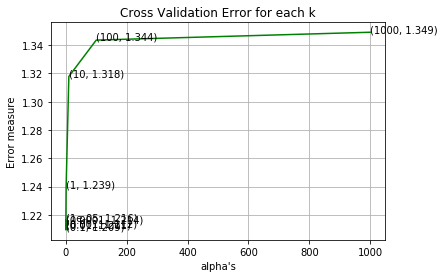

For values of best alpha =  0.1 The train log loss is: 1.0694436763093575
For values of best alpha =  0.1 The cross validation log loss is: 1.2092870903105566
For values of best alpha =  0.1 The test log loss is: 1.319636406549805


In [28]:
alpha = [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000 ]
cv_log_error = []
for i in alpha:
  clf=MultinomialNB(alpha=i)
  clf.fit(train_text_feature_tfidf,y_train)
  sig_clf=CalibratedClassifierCV(clf,method='sigmoid')
  sig_clf.fit(train_text_feature_tfidf,y_train)
  predicted_y=sig_clf.predict_proba(cv_text_feature_tfidf)
  cv_log_error.append(log_loss(y_cv,predicted_y,labels=clf.classes_,eps=1e-15))
  print("For the alpha value ",i,"the logg loss is :",log_loss(y_cv,predicted_y,labels=clf.classes_,eps=1e-15))


fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error,c='g')
for i, txt in enumerate(np.round(cv_log_error,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error[i]))
plt.grid()
plt.title("Cross Validation Error for each k")
plt.xlabel("alpha's")
plt.ylabel("Error measure")
plt.show()


best_alpha_text = np.argmin(cv_log_error)
clf = MultinomialNB(alpha=alpha[best_alpha_text])
clf.fit(train_text_feature_tfidf, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_tfidf, y_train)

predict_y_text = sig_clf.predict_proba(train_text_feature_tfidf)
print('For values of best alpha = ', alpha[best_alpha_text], "The train log loss is:",log_loss(y_train, predict_y_text, labels=clf.classes_, eps=1e-15))
predict_y1_text = sig_clf.predict_proba(cv_text_feature_tfidf)
print('For values of best alpha = ', alpha[best_alpha_text], "The cross validation log loss is:",log_loss(y_cv, predict_y1_text, labels=clf.classes_, eps=1e-15))
predict_y2_text = sig_clf.predict_proba(test_text_feature_tfidf)
print('For values of best alpha = ', alpha[best_alpha_text], "The test log loss is:",log_loss(y_test, predict_y2_text, labels=clf.classes_, eps=1e-15))


In [0]:
#Data preparation for ML models.

#Misc. functionns for ML models


def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [0]:
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

In [31]:
# merging gene, variance and text features

# building train, test and cross validation data sets
# a = [[1, 2], 
#      [3, 4]]
# b = [[4, 5], 
#      [6, 7]]
# hstack(a, b) = [[1, 2, 4, 5],
#                [ 3, 4, 6, 7]]

train_gene_var_tfidf = hstack((train_gene_feature_tfidf,train_var_feature_tfidf))
cv_gene_var_tfidf = hstack((cv_gene_feature_tfidf,cv_var_feature_tfidf))
test_gene_var_tfidf = hstack((test_gene_feature_tfidf,test_var_feature_tfidf))
print("Shape of Gene feature in Train data is :",train_gene_feature_tfidf.shape[0])
print("Shape of Variation feature in Train data is :",train_var_feature_tfidf.shape[0])
print("Shape of Gene and Variation feature in Train data is :",train_gene_var_tfidf.shape[0])

train_x_tfidfCoding = hstack((train_gene_var_tfidf, train_text_feature_tfidf)).tocsr()
train_y = np.array(list(X_train['Class']))

test_x_tfidfCoding = hstack((test_gene_var_tfidf, test_text_feature_tfidf)).tocsr()
test_y = np.array(list(X_test['Class']))

cv_x_tfidfCoding = hstack((cv_gene_var_tfidf, cv_text_feature_tfidf)).tocsr()
cv_y = np.array(list(X_cv['Class']))

Shape of Gene feature in Train data is : 2124
Shape of Variation feature in Train data is : 2124
Shape of Gene and Variation feature in Train data is : 2124


In [32]:
print("Tfidf encoding features :")
print("(number of data points * number of features) in train data = ", train_x_tfidfCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_tfidfCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_tfidfCoding.shape)

Tfidf encoding features :
(number of data points * number of features) in train data =  (2124, 7355)
(number of data points * number of features) in test data =  (665, 7355)
(number of data points * number of features) in cross validation data = (532, 7355)


<h2> Build Naive bayes Model :

For the alpha value  1e-05 the logg loss is : 1.1662914138688885
For the alpha value  0.0001 the logg loss is : 1.1659031009153713
For the alpha value  0.001 the logg loss is : 1.166580125655669
For the alpha value  0.01 the logg loss is : 1.1658009352077312
For the alpha value  0.1 the logg loss is : 1.1659047934585354
For the alpha value  1 the logg loss is : 1.1878750950784593
For the alpha value  10 the logg loss is : 1.2147863792908309
For the alpha value  100 the logg loss is : 1.242972206974537
For the alpha value  1000 the logg loss is : 1.248557166814922


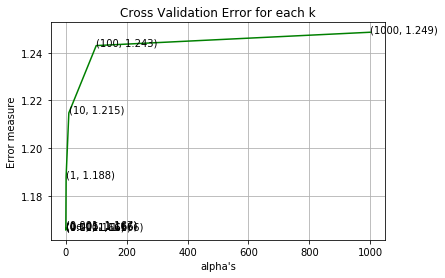

For values of best alpha =  0.01 The train log loss is: 0.6615504443360763
For values of best alpha =  0.01 The cross validation log loss is: 1.1658009352077312
For values of best alpha =  0.01 The test log loss is: 1.3009368891221564


In [33]:
alpha = [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000 ]
cv_log_error = []
for i in alpha:
  clf=MultinomialNB(alpha=i)
  clf.fit(train_x_tfidfCoding,y_train)
  sig_clf=CalibratedClassifierCV(clf,method='sigmoid')
  sig_clf.fit(train_x_tfidfCoding,y_train)
  predicted_y=sig_clf.predict_proba(cv_x_tfidfCoding)
  cv_log_error.append(log_loss(y_cv,predicted_y,labels=clf.classes_,eps=1e-15))
  print("For the alpha value ",i,"the logg loss is :",log_loss(y_cv,predicted_y,labels=clf.classes_,eps=1e-15))


fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error,c='g')
for i, txt in enumerate(np.round(cv_log_error,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error[i]))
plt.grid()
plt.title("Cross Validation Error for each k")
plt.xlabel("alpha's")
plt.ylabel("Error measure")
plt.show()


best_alpha_model = np.argmin(cv_log_error)
clf = MultinomialNB(alpha=alpha[best_alpha_model])
clf.fit(train_x_tfidfCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidfCoding, y_train)

predict_y_model = sig_clf.predict_proba(train_x_tfidfCoding)
print('For values of best alpha = ', alpha[best_alpha_model], "The train log loss is:",log_loss(y_train, predict_y_model, labels=clf.classes_, eps=1e-15))
predict_y1_model = sig_clf.predict_proba(cv_x_tfidfCoding)
print('For values of best alpha = ', alpha[best_alpha_model], "The cross validation log loss is:",log_loss(y_cv, predict_y1_model, labels=clf.classes_, eps=1e-15))
predict_y2_model = sig_clf.predict_proba(test_x_tfidfCoding)
print('For values of best alpha = ', alpha[best_alpha_model], "The test log loss is:",log_loss(y_test, predict_y2_model, labels=clf.classes_, eps=1e-15))


**Testing model with best hyper-parameter :**

Log loss : 1.3009368891221564
Number of mis-classified points : 0.42857142857142855
-------------------- Confusion matrix --------------------


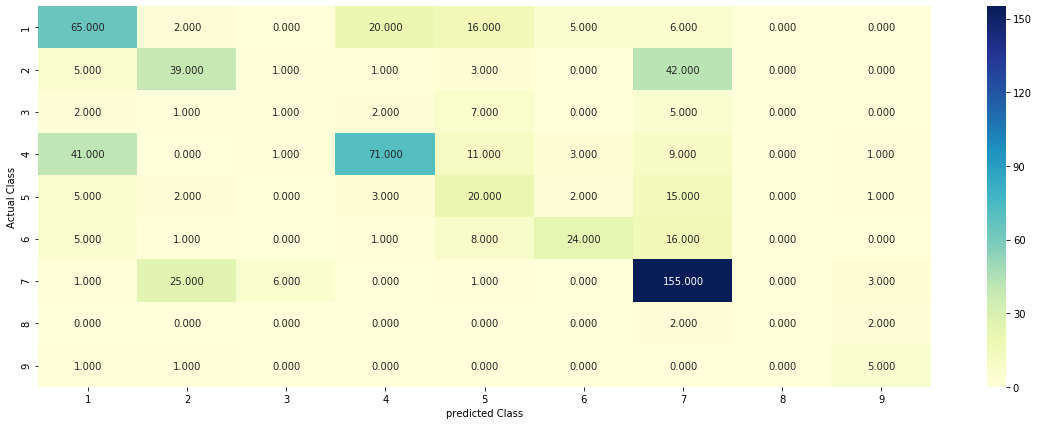

-------------------- Precision matrix (Column Sum = 1) --------------------


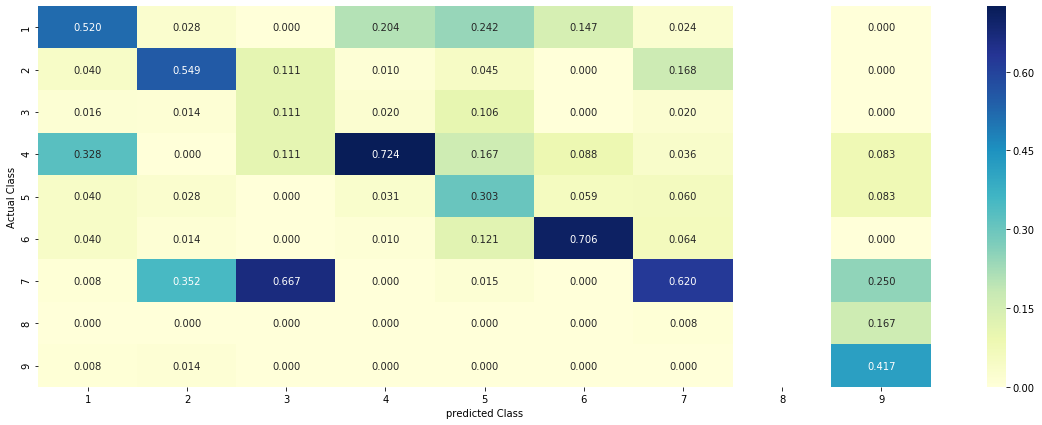

-------------------- Recall matrix (Row Sum = 1) --------------------


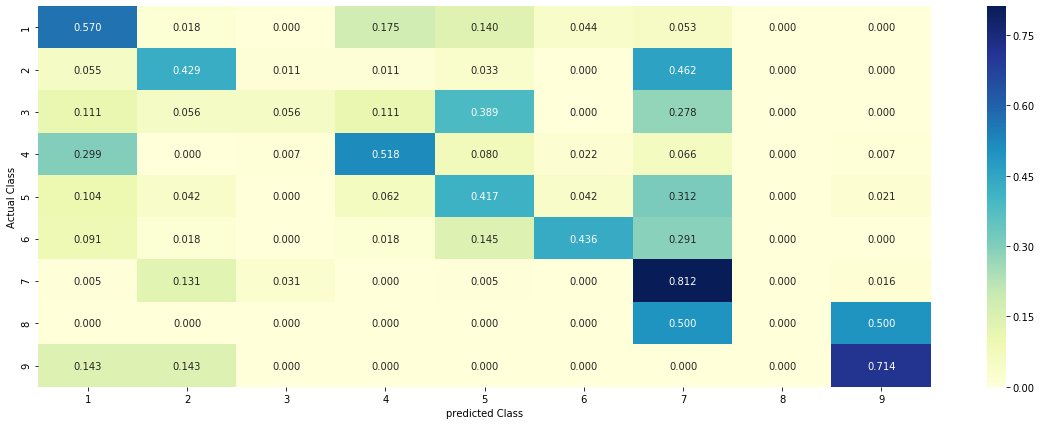

In [34]:
clf = MultinomialNB(alpha=alpha[best_alpha_model])
predict_and_plot_confusion_matrix(train_x_tfidfCoding, y_train, test_x_tfidfCoding, y_test, clf)

<h4> Feature Importance, Correctly classified point</h4>

In [35]:
test_point_index = 10
no_feature = 100
predicted_cls = clf.predict(train_x_tfidfCoding[test_point_index])
print(predicted_cls)
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(train_x_tfidfCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])


[1]
Predicted Class : 1
Predicted Class Probabilities: [[0.6261 0.0536 0.0136 0.1158 0.0399 0.0409 0.1033 0.0033 0.0035]]
Actual Class : 1


Here, if we observe the Predicted class probabilities the class 1 probability was higher than other class probabilities hence it was declaring the Predicted Class as 1.

<h4> Feature Importance, Incorrectly classified point</h4>

In [36]:
test_point_index = 100
no_feature = 100
predicted_cls = clf.predict(train_x_tfidfCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(train_x_tfidfCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])


Predicted Class : 2
Predicted Class Probabilities: [[0.0661 0.5596 0.0144 0.0853 0.0435 0.0436 0.1804 0.0035 0.0037]]
Actual Class : 1


Here, if we observe the Predicted class probabilities the class 2 probability was higher than other class probabilities hence it was declaring the Predicted Class as 2, but the actual class was 1.

In [37]:
from prettytable import PrettyTable

x=PrettyTable()
x.field_names = ["Feature_Name","Best Hyperparameter","Train Log_Loss","CV Log_Loss","Test Log_Loss"]
x.add_row(["Gene", alpha[best_alpha_gene],log_loss(y_train, predict_y_gene, labels=clf.classes_, eps=1e-15), log_loss(y_cv, predict_y1_gene, labels=clf.classes_, eps=1e-15),log_loss(y_test, predict_y2_gene, labels=clf.classes_, eps=1e-15)])
x.add_row(["Variation", alpha[best_alpha_var],log_loss(y_train, predict_y_var, labels=clf.classes_, eps=1e-15),log_loss(y_cv, predict_y1_var, labels=clf.classes_, eps=1e-15),log_loss(y_test, predict_y2_var, labels=clf.classes_, eps=1e-15)])
x.add_row(["Text", alpha[best_alpha_text],log_loss(y_train, predict_y_text, labels=clf.classes_, eps=1e-15),log_loss(y_cv, predict_y1_text, labels=clf.classes_, eps=1e-15),log_loss(y_test, predict_y2_text, labels=clf.classes_, eps=1e-15)])
x.add_row(["Gene+Variation+Text", alpha[best_alpha_model],log_loss(y_train, predict_y_model, labels=clf.classes_, eps=1e-15),log_loss(y_cv, predict_y1_model, labels=clf.classes_, eps=1e-15),log_loss(y_test, predict_y2_model, labels=clf.classes_, eps=1e-15)])
print(x)

+---------------------+---------------------+--------------------+--------------------+--------------------+
|     Feature_Name    | Best Hyperparameter |   Train Log_Loss   |    CV Log_Loss     |   Test Log_Loss    |
+---------------------+---------------------+--------------------+--------------------+--------------------+
|         Gene        |         0.1         | 1.0726203394183564 | 1.2380940279209514 | 1.3031363754975405 |
|      Variation      |          10         | 1.3913138101882896 | 1.697635071093964  | 1.7324416685743982 |
|         Text        |         0.1         | 1.0694436763093575 | 1.2092870903105566 | 1.319636406549805  |
| Gene+Variation+Text |         0.01        | 0.6615504443360763 | 1.1658009352077312 | 1.3009368891221564 |
+---------------------+---------------------+--------------------+--------------------+--------------------+


As we know Naive Bayes will work better when we have text data. So if we observe the prettytable we can clearly see that with the Gene and Varaiation and Text feature we got the low log-loss when it compare with univariate analysis of Gene, Variation, Text feature.